<a href="https://colab.research.google.com/github/TUIlmenauAMS/GVT_Lecture_Colab/blob/main/GVT_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture Fundamentals of Video Technology**

## Gerald Schuller

## gerald.schuller@tu-ilmenau.de

###**Lecture Video part 1:**

https://youtu.be/uS4ANazNcsk


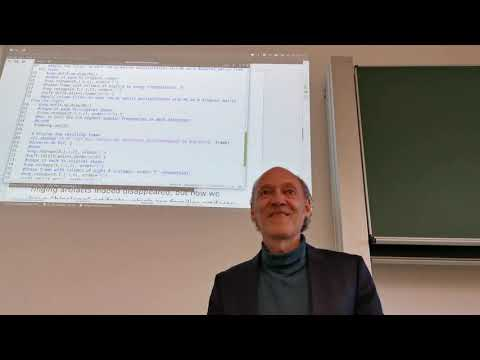

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('uS4ANazNcsk')

###**Lecture Video part 2:**

https://youtu.be/_-jG1m11Ag0

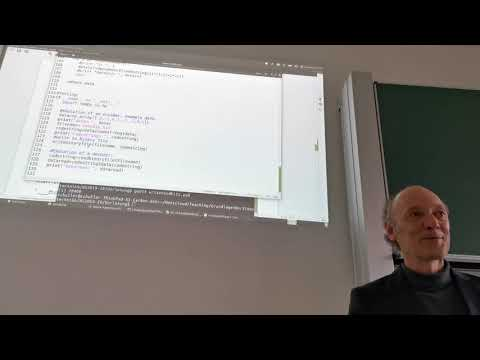

In [2]:
YouTubeVideo('_-jG1m11Ag0')

#**Quantization, conversion of values into bits**
We have seen that for pure brightness values we need about 100 steps, for which 7 bits are sufficient. What is the situation with DCT coefficients? We saw with the Contrast Sensitivity Function that the eye has different sensitivity for different spatial frequencies. Since our **DCT coefficients** now represent **different spatial frequencies**, this also results in different sensitivities.

How do we establish the connection between the **DCT coefficients** or sub-bands and the **spatial frequencies** (in brightness oscillations or periods per degree)? To do this, we need to know how many pixels per degree appear to the eye at a given viewing distance and pixel size. 

**Example**: We have a 50cm wide screen with 1000 pixels over this width and a viewing distance of 50cm.

1 pixel has the width of 50cm/1000=5/100 cm. It appears under an angle of arctan ((5cm/100)/50cm)=1e-3 Rad=0.057 Degrees.
So we get 1/0.057=17.45 pixel/degrees.
Since each pixel represents a sampled value, this now corresponds to the **sampling frequency**.
The Nyquist frequency is therefore 17.45/2=8.725 periods/degree.

The 8x8 block based DCT divides the frequency range from **0 to Nyquist** into 8 equal **subbands**. Each has a width of 8,725/8=1,0906 periods/degree.

In this way, we have now obtained an assignment of the sub-bands or coefficients (the index k) of the DCT to the spatial frequency. The Contrast Sensitivity Function then shows us the **relative sensitivity** of the eye to the **different** sub-bands.

This in turn shows us how best to quantize the DCT coefficients. The **higher** the **contrast sensitivity** in a subband, **the more accurate** we have to quantize the corresponding DCT coefficient. The coefficients of the **higher spatial frequencies** tend to require a **lower accuracy** and thus **fewer bits**.

How do we now **convert** our **DCT coefficients into bits** with appropriate accuracy?

We can divide our possible range of values into equal **intervals**. We can then assign an **index** to each of these intervals, which we can display and transfer with a binary **code word**. 

Depending on whether the value "0" appears in the middle or at the edge of a quantization interval, we distinguish between the so-called "**Mid-Tread**" and "**Mid-Rise**" quantizers.

**Example**: The **Mid-Tread** quantizer (see: https://en.wikipedia.org/wiki/Quantization_ (signal_processing). 

In the encoder and for the Mid-Tread case, the index I is calculated from a value, $x$, by means of a simple rounding, according to the formula

$$I=round(\frac{x}{Δ})$$

where Δ is the **quantization stepsize**. The reconstructed value,  $x_{rek}$,  is calculated in the **decoder** by the so-called **de-quantizer**, using the formula

$$x_{rek}=I⋅Δ$$

If we want to use b bits to represent the indices of this range of values, index 0 represents the smallest possible value "min", and the largest index $2^b-1$ represents the largest possible value "max" (if b is the number of bits we want to spend on the index), then
we can divide the value range (max-min) into $2^b-1$ equal intervals. Each interval then has the step height Δ of

$$Δ=\frac{max-min}{2^b-1}$$

**Note**: This formula also works for b=0 bits (no transfer) if we replace 1 with 0.99 to avoid division by 0!

The difference between original and reconstruction is the “quantization error” $e$

$$e=x_{rek}-x$$


**Example**: We have our normalized range with min=0 and max=1, b=2 bits and x=0.3.
Then our quantization step size is

$$Δ=\frac{max-min}{2^b-1}=\frac{1}{3}=0.33...$$

the quantization index is

$$I=round(\frac{x}{Δ})=round(\frac{0.3}{0.33...}=round(0.9)=1$$

the reconstructed value in the decoder is

$$x_{rek}=I⋅Δ=1⋅0.33...-0.3=0.033...$$

and the quantization error is

$$e=x_{rek}-x=0.33...-0.3=0.033...$$

**Example of the binary representation** of the index for transmission from the encoder to the decoder, here including negative numbers:

2 bits or 4 indices:

|Index|Binary representation(code word)|
|----------|:------------|
|0|00|
|1|01|
|-2|10
|-1|11|

The binary representation is also called "**code word**".

**Note** that the example shows the so-called **two's complement** for negative numbers, see also https://de.wikipedia.org/wiki/Zweierkomplement 

or

https://en.wikipedia.org/wiki/Two%27s_complement

The code word for negative numbers is obtained by taking the binary representation of the positive number, inverting its bits and adding 1.

**Note**: The rounded up logarithm to base 2 of the number of indexes ($MaxIndex-MinIndex+1$) indicates the required **number of bits**:

$$bitnumber=ceil(log_2(MaxIndex-MinIndex+1))$$

In the above example: 

$$bitnumber=ceil(log_2(4))=ceil(\frac{log(4)}{log(2)})=2$$

#**Implementing in Python**
The conversion of indexes to and from code words works best in Python with the so called. “**Dictionaries**”.

Example: Dictionary for converting an index (e. g. index=-1) into a code word:
The “codebook” is defined as:

In [3]:
codeword={0:'00',1:'01',-2:'10',-1:'11'}

The conversion from index to code word (coding) is done by:

In [4]:
codeword[-1]

'11'

This binary codeword is then transmitted to the decoder. The decoder needs to convert the codeword back into an index first. The conversion of a code word into an index in the decoder is done by defining the reverse Dictionary

In [5]:
decodeword={'00':0,'01':1,'10':-2,'11':-1}

and then decode with

In [6]:
decodeword['11'] 

-1

#**Python example for direct quantization of the pixels of the Y-component of the video frames:**
We generate the quantization steps with:

In [7]:
import numpy as np

bits=2 
#resulting quantization step size for 2^bits steps, with min=0 and max=1: 
#Dividing the value range by the number of
#available quantization intervals, 
#to obtain the quantization step size:
quantstufe=1.0/(2**bits-1)

The quantization indices are calculated from the frame Y with:

In [11]:
import cv2

cap = cv2.VideoCapture(0)

[retval, frame] = cap.read()    
Y=(0.114*frame[:,:,0]+0.587*frame[:,:,1]+0.299*frame[:,:,2])/255;

#Apply mid-tread for the encoder:
indices=np.round(Y/quantstufe)

TypeError: ignored

So all pixels get the same quantization step size. 
The de-quantization (in the decoder) is then the mid-tread formula for the decoding side:

In [ ]:
Yrek=indices*quantstufe

**Calling** the program:

*python videorecprocyquant.py*

**We see: The fewer bits** per pixel we use, **the fewer brightness levels** we have and the more visible the light jumps become.

#**Python example for quantization of the 8x8 DCT coefficients:**
In this example we quantize all coefficients of the **8x8 DCT**. Because of the Parseval theorem we have to **adjust the range of values**. It can happen that the total signal energy of all 64 pixels of a block is concentrated in the DC coefficient, e. g. when all pixels are equal. Then this coefficient contains 64 times the energy. The root of it is the factor for our signal is the factor 8. It is beneficial to observe the values with real pictures and then adjust them accordingly. There, the value range from 0 to 5 can be obtained for the DC coefficients, and the value range -0.5... 0.5 for the other (AC) coefficients.

In python:

In [ ]:
bits=2 
#resulting quantization step size for 2^bits steps: 
#Steps for different spatial frequencies: 
#DC indices with range 0...5: 
quantstufeDC=5.0/(2**bits-1)
#Two AC coefficients, with range 0.5-(-0.5)
bits=2
quantstufeAC=1.0/(2**bits-1)

Calculation of the indices for the DC coefficients, every 8th coefficient horizontally and vertically:

In [12]:
import scipy.fftpack as sft

[r,c,d]=frame.shape

#First reshape green frame as frame with rows of width 8, (rows: order= 'C' ), 
#and apply DCT to each row of length 8 of all blocks:
frame=np.reshape(frame[:,:,1],(-1,8), order='C')
X=sft.dct(frame/255.0,axis=1,norm='ortho')
    
#shape it back to original shape:
X=np.reshape(X,(-1,c), order='C')
#Shape frame with columns of hight 8 by using transposition .T:
X=np.reshape(X.T,(-1,8), order='C')
X=sft.dct(X,axis=1,norm='ortho')
   
#shape it back to original shape:
X=(np.reshape(X,(-1,r), order='C')).T

indices00=np.round(X[0::N,0::N]/quantstufeDC)

AttributeError: ignored

For 2 AC coefficients (the others are omitted for the sake of clarity):

In [ ]:
indices01=np.round(X[0::N,1::N]/quantstufeAC) 
indices10=np.round(X[1::N,0::N]/quantstufeAC) 

NameError: ignored

###De-quantization:

In [ ]:
#de-quantization in the decoder: 
Xrek=np.zeros((r,c));
#DC values de-quantization: 
Xrek[0::N,0::N]=indices00*quantstufeDC 
#2 AC values de-quantization: 
Xrek[0::N,1::N]=indices01*quantstufeAC 
Xrek[1::N,0::N]=indices10*quantstufeAC

NameError: ignored

**Calling** the Prorgam:

    python videorecdctblocksidctquant.py

**We see**: Instead of long contours in the lightness jumps we now have **blocking artifacts**, similar to low pass filtering.

#**Writing bits to files in Python**
The smallest unit we can write to a file in Python is 1 byte (8 bits). Since we only have 2 bit per index in the example, we must first form a bitstream, which we then divide into bytes.   We generate the bit stream by connecting **codewords** with

In [ ]:
bitstring=bitstring+codeword[value]

NameError: ignored

where "value" is our index to be coded. We implement this as a function '*data2codestring*' in  File *writereadbits.py*.

Converting the **code string** into a **sequence of 8-bit numbers** is done with the command "eval", which executes a string (in the writebinaryfile function of the writereadbits. py library) which converts it into numbers:

In [ ]:
for m in range(numbytes):
	   Bytes[m]=eval('0b'+bitstring[m*8:(m*8+8)])

NameError: ignored

Here partial strings of 8 characters each are evaluated, with the string' 0b' at the beginning they are interpreted as binary numbers, which are written into the array "Bytes". 

The conversion of **the array** of 8-bit numbers into a **stream of bytes** is done with the command

In [ ]:
import struct

s=struct.pack('B'*len(Bytes), *Bytes)

NameError: ignored

'B' means: unsigned byte, because we already have the sign in our code words. bytes means: Pointer to our array with 8-bit numbers, i. e. integers between 0 and 255. 

###**Example:**

In [ ]:
import struct
import numpy as np
bitstring='000000010000001011111111'
#Erzeugen unseres Arrays aus 8-bit Zahlen:
Bytes=np.zeros(3,dtype=int)
for m in range(3):
	   Bytes[m]=eval('0b'+bitstring[m*8:(m*8+8)])
Bytes
#array([  1,   2, 255])
#Erzeugen des Byte-Stroms:
s=struct.pack('B'*len(Bytes), *Bytes)
s

b'\x01\x02\xff'

'\x..' means a "hexadecimal" number whose digits consist of 4 bits. 4 bits can accept 16 values, e. g. between 0 and 15.10 to 15 values are represented by the letters 'a' to 'f'. Hence the hexadecimal number 'ff' for 255, which consists of two binary numbers '1111', ie hexadecimal 'f'.

We can then write this stream to a file, with

In [ ]:
file=open(filename, "wb") 
#'w' deletes exisiting file, 'a' appends 
file.write(s) 
file.close()

NameError: ignored

We implement this as a function '*writebinaryfile*' in the file '*writereadbits.py*'.

In the **decoder** we have to reopen this file and read the byte stream:

In [ ]:
file=open(filename, "rb") 
#read the stream from file: 
readdata=file.read() 
#unpacks the stream into an array of Bytes: 
Bytesread=struct.unpack('B'*len(readdata),readdata)

NameError: ignored

Afterwards we create a bitstream from it, by creating bits from the bytes and connecting them to each other:

In [ ]:
for byte in Bytesread: 
	   #create bit string from byte: 
	   bits=bin(byte) 
	   #remove leading '0b' and fill up to 8 bits with leading zeros: 
bits=bits[2:].zfill(8) 
	   #append to bits to bitstring: 
bitstring=bitstring+bits

NameError: ignored

Our data values (or quantization indices) are then translated from the pairs of 2 in the bit string:

In [ ]:
decodeword={'00':0,'01':1,'10':-2,'11':-1} 
	#convert sequence of Bytes into sequence of bits: 
numdata=len(bitstring)/2; 
        #converts groups of 2 bits into data: 
data=np.zeros(numdata,dtype=int) 
n=0; 
for i in range(numdata): 
            data[n]=decodeword[bitstring[(i*2):(2+i*2)]] 
            n+=1


TypeError: ignored

The following functions serve as an **example** for translating a data array from our quantization indexes into strings from code words and back, *data2codestring* and *codestring2data*, in the file *writereadbits.py*. The code string can be defined using the functions *writebinaryfile* and *readbinaryfile* written to a binary file or read from it.

We test these functions with:

    python writereadbits.py

**Note**: The test routine is only activated when you call the function directly under “*if __name__ == '__main__':*” not when importing the file.

**Note**: The test function shows: The functions *data2codestring* and *writebinaryfile* write a sequence of indexes with 2 bit each into the file '*savebin.bin*', and *readbinaryfile* and *codestring2data* decode the same sequence again.

#**Example of a frame encoder and decoder in Python:**
The following **encoder** takes the lowest 3 DCT coefficients (at the positions (0,0), (0,1), and (1,0), quantizes them with 2 bit each, and stores them in their own file.  For simplicity's sake, we define the 8x8 pixel blockwise DCT and inverse DCT as function '*dct8x8*' or '*invdct8x8*' in the file '*blockdct.py*'. The size of the frame is additionally written in a text file for the decoder. 

We start the encoder with

    python frameencfile.py

We see the live video and save a frame when we press "*c" (capture*), in the files *y10enc. bin, y01enc. bin, y00enc. bin, framedim. txt*.

If we look at the total size of the files, we get only **3.6 kB**, an **extreme compression** for a 480x640 pixel image!

The corresponding **decoder** is started with:

    python framedecfile.py

This automatically reads the encoder's files, decodes the image and displays it. 

**As we can see**, it is very blocky and has only a few shades of gray, a consequence of extreme compression. But we can still see the content of the picture well.

#**The Color Image Coder**
By including the color components U and V (or Cb and Cr), our coder can be expanded to a color image encoder. Since the eye is sensitive to the color components at lower spatial frequencies than to the brightness in the luminance component Y, we limit ourselves to coding the DC coefficients (position (0,0)) of the block wise DCT of the color components U and V.

The call of the encoder is most appropriate in a **subdirectory** for the resulting compressed image files:

    mkdir Pic1; cd Pic1

    python ../picturecolorencoder.py

The decoder is then started with

    python ../picturecolordecoder.p

**Note**: The resulting files of the compressed color image have a total size of only about **6KB**, i. e. only about **0.16 bit/pixel** at 480x640 pixel image size!
The resulting decoded image has clear artifacts (partly "artistic" in appearance), but the image content is still clearly visible. 

#**Python example for the different quantization of the DCT coefficients:**
In order to use the different sensitivity of the eye for different spacial frequencies in order to improve the result, we quantize the respective DCT coefficients differently. We use the **Contrast Sensitivity Function** here only qualitatively.

Reminder: In slide set 4 we saw the Contrast Sensitivity Function (CSF):

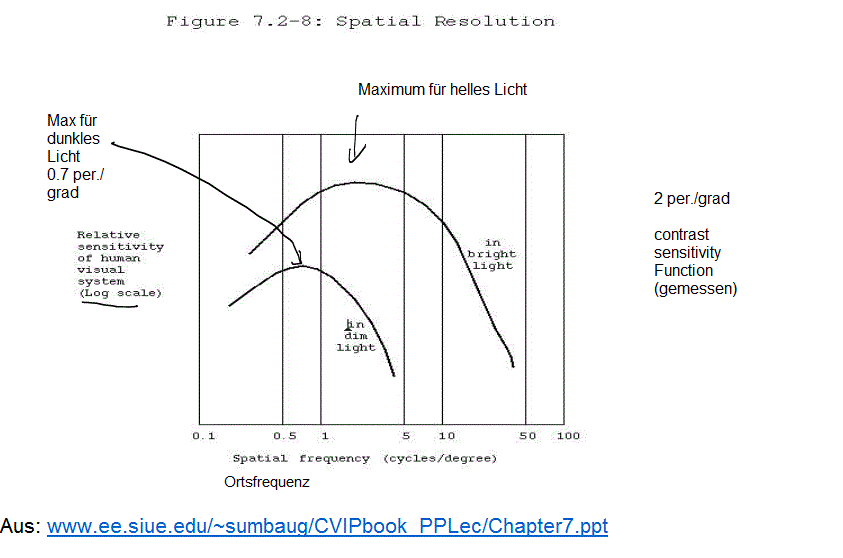

We assume that the spatial frequency range of the DC coefficient of the DCT is already in the maximum of the CSF (according to our example above, where we found about 1 period/degrees per DCT subband and fitting to the curve for dark light). We therefore use the most accurate quantization for the DC value,  so we use the characteristic of the eye that it becomes increasingly **insensitive** to **high spatial frequencies** (fine patterns). For the coefficients with a constant sum s=k+l (for k,l: horizontal and vertical DCT subband indices)  we select the same quantization level, because they correspond to roughly to **edges of the same slope** in different directions. This results in anti-diagonals with the same quantization step-size in our quantization matrix. At the top left is DC  with **the highest accuracy (low quantization step sizes)**, down to the right, towards **high spatial frequencies**, the accuracy becomes smaller and **smaller (higher quantization step sizes)**.

This will give us a more detailed quantization mask. To make it in python we use the command *np.diag*, which creates a diagonal matrix with a given offset from the main diagonal:

In [ ]:
B=np.diag([1,2,3]) 
B

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

to make it an anti-diagonal:

In [ ]:
np.fliplr(B)

array([[0, 0, 1],
       [0, 2, 0],
       [3, 0, 0]])

and np.tril, which generates a lower triangle matrix:

In [ ]:
np.tril(np.ones((4,4)),1)

array([[1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

This is now our quantization matrix M:

In [ ]:
#Steps for different spatial frequencies:
bits=4 
quantstep1=5.0/(2**bits-1) 
bits=3 
quantstep2=1.0/(2**bits-1) 
bits=2 
quantstep3=0.6/(2**bits-1) 
bits=1 
quantstep4=0.4/(2**bits-1) 
bits=0 
quantstep5=8.0/(2**bits-0.99) #vermeide div. durch 0! 
#Zus.: 1*4 bits + 2* 3 bits + 3*2bits + 4*1 bits, 20bits fuer 64 pixel, also 0.3125 bit pro pixel! 
#Quantization steps in "mask", anti-diagonals have the same quantization steps: 
M=np.zeros((8,8)) 
M[0,0]=quantstep1 
M=M+  np.fliplr(np.diag([1,1],6))*quantstep2 
M=M+  np.fliplr(np.diag([1,1,1],5))*quantstep3 
M=M+  np.fliplr(np.diag([1,1,1,1],4))*quantstep4 
M=M+  np.fliplr(np.tril(np.ones((8,8)),3))*quantstep5
print(M[0:3,0:3])

[[3.33333333e-01 1.42857143e-01 2.00000000e-01]
 [1.42857143e-01 2.00000000e-01 4.00000000e-01]
 [2.00000000e-01 4.00000000e-01 8.00000000e+02]]



We then apply this matrix to each 8x8 DCT block. Each DCT coefficient is divided by the corresponding value in the quantization matrix M. Note that the coefficient in the upper left corner corresponds to the DC coefficient, and thus to the lowest spatial frequency. To the right and down, the corresponding spatial frequencies are getting higher and higher, so we can quantize them more and more coarsely.

We get
* 4 bit for the DC coefficient, 
* 3 bit for the following anti-diagonal, which consists of 2 coefficients, then 
* 2 bit for the following 3 coefficients on the next antidiagonal, 
* 1 bit for the next 4 coefficients, and
* 0 bit for the rest.
In this way we need the following number of bits per 8x8 pixel block:
1*4 bits + 2* 3 bits + 3*2 bits + 4*1 bits=20 bits for 64 coefficients or pixels, thus **only 0.3125 bits per pixel**!

For our frame, we only have to repeat this small 8x8 matrix-mask until it fills up the whole frame. We do this with the command np.kron. It implements the so-called Kronecker product. 
An example:

\begin{equation*}
A = 
\begin{bmatrix}
1 & 1\\
1 & 1
\end{bmatrix}
\end{equation*}
and M is our matrix mask.

Then apply:

\begin{equation*}
np.kron(A,M) = 
\begin{bmatrix}
M & M \\
M & M
\end{bmatrix}
\end{equation*}

So we can easily repeat our mask up to frame size.
In our example:

In [ ]:
r8=r/8 
c8=c/8 
Mframe=np.kron(np.ones((r8,c8)),M);

NameError: ignored

Then we **quantize** with the element-wise matrix division:

In [ ]:
index=np.round (X/ Mframe)

NameError: ignored

and **de-quantize** with element-wise matrix multiplication:

In [ ]:
Xrek=indices*Mframe

NameError: ignored

**Calling** the Python program:

    python videorecdctblocksidctquantmask.py

**Note**: Despite the significantly lower bit rate of 0.3125 bits/pixel we have a significantly better quality than the examples with the same quantization height at 2 bits/pixel! But observe that we neglected the range clipping from using a fixed number of bits in this example.
Since we have used the Contrast Sensitivity Function here only qualitatively and very roughly, we can expect **clear improvements** with more **precise application of the CSF**!

#**Example JPEG compression:**
JPEG stands for "Joint Photographic Expert Group", which has released the JPEG standard for image compression and encoding. This format is known from digital cameras, for example. It is also based on splitting the image into 8x8 pixel blocks, then a 2D DCT of these blocks, and then a quantization of the DCT coefficients. Our quantization mask M is called "Q" here. For a "Quality" setting of 50%, JPEG uses the following quantization mask:

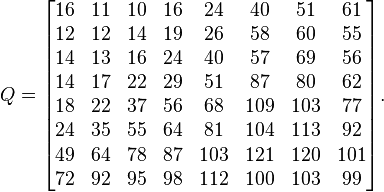

**Note**: Here we also see the smallest quantization-step-size at the DCT-coefficients of the small spatial frequencies, top left, with the highest accuracy. To the lower right, towards the coefficients of the higher spatial frequencies, the quantization step sizes become larger and larger, i. e. the quantization becomes inaccurate. 

Note also that the number range for the quantization steps is different here, because an un-normalized image is assumed (pixels in the range 0 to 255), unlike in our example, where the image has been normalized, to pixel values in the range 0 to 1.
(See also: http://en.wikipedia.org/wiki/JPEG)

#**Python example with JPEG quantization matrix:**


    python videorecdctblocksidctquantjpgmask.py

**Note**: The quality of the reconstructed video is not much better (but somewhat, in the finer details of the picture, by including more higher spatial frequencies), but now at a bit-rate that is not exactly known. The number of bits in JPEG is variable and depends on the image, because it uses Huffman coding, with variable lengths of codewords.

#**Conversion into a sequence of indices or bits**
In JPEG, after quantization of the DCT coefficients and conversion into bits, the so-called "zigzag scan" follows. The following figure shows an 8x8 block of DCT coefficients, with the DC coefficient at the top left:

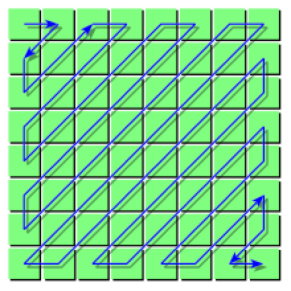

Thus, the coefficients are sorted by importance or bit length, and the transmission can be stoped in one place, depending on the "Quality" level (see Reimers:"DVB-Digital TV technology").

#**JPEG Processing steps:**
##**Encoder:**
- Y Cr Cb Color transform
- Subsampling of Cr, Cb (4:2:0)
- Apply 2D-DCT to 8x8 pixel blocks on the 3 components
-Quantization using the quantization matrix
-Conversion of the indices from quantization to bits.

##**Decoder:**
- Conversion of the bits into indices
- De-quantization of indices into reconstructed values
- Inverse 2D-DCT on the 8x8 blocks of the 3 components
- Upsampling of Cr, Cb and conversion back to RGB.
(See also: U. Reimers:"DVB-Digital television technology", Springer)

##**Tips for debugging**
- Divide a program into small functional units (e. g. functions), which can be tested individually for themselves
-Use "print" commands, starting from the front (where it should be correct) and back (where it migth be buggy) to the middle of a program, to narrow down in which area an error (bug) has to occur until it is found.
